In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np
import keras
import gc
from keras.constraints import max_norm
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
dates=list() 
prices=list()
sentiment=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/AffectiveSpace/Aggregated_AffectTitle_dataset15/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    #sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDataset/SentimentFul/'+file+'.csv')
    #price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price['Unnamed: 0'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['Unnamed: 0']]
    price['Unnamed: 0'] = [row-timedelta(hours=8) for row in price['Unnamed: 0']]
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    print(file)
    dates.append(price['Unnamed: 0'])
   
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,sentimentVector.rolling(5).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(10).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(15).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(20).mean()),axis=1)
    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    prices.append(price)

/home/andrea/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL
AMZN
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d,le):
    opt=optimizers.SGD(lr=le, decay=1e-6, momentum=0.9, nesterov=True)
    model = Sequential()  
    model.add(Dense(n, input_dim=505,kernel_constraint=max_norm(1),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2),kernel_constraint=max_norm(1), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4),kernel_constraint=max_norm(1), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    #o
    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
           


Working on... AAPL
15.571701720841297
0.005338458253266777
working on d,u and l,le 0.5 512 0.01 0.0001


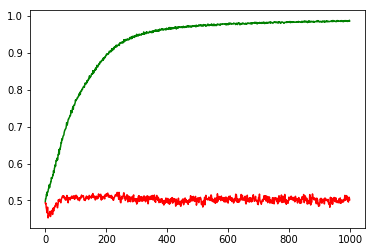

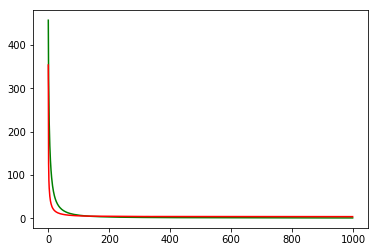

working on d,u and l,le 0.5 512 0.01 1e-05


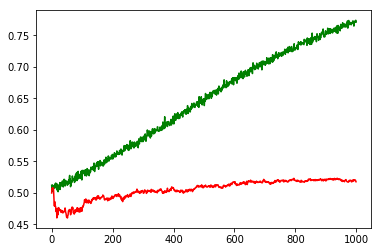

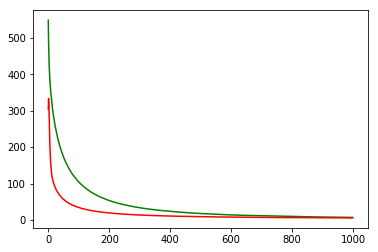

working on d,u and l,le 0.5 756 0.01 0.0001


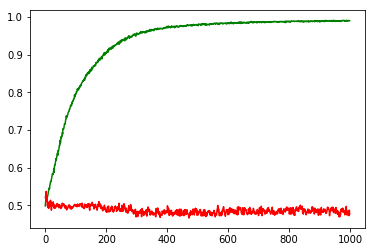

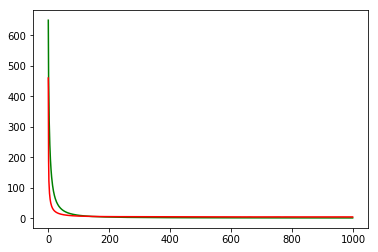

working on d,u and l,le 0.5 756 0.01 1e-05


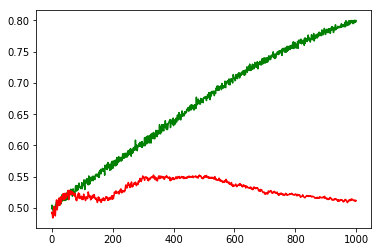

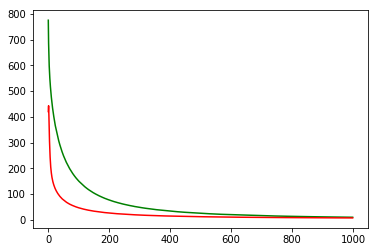

maxd,maxu,maxl,maxle: 0.5 512 0.01 1e-05
Chart for BEST MODEL FOR: AAPL


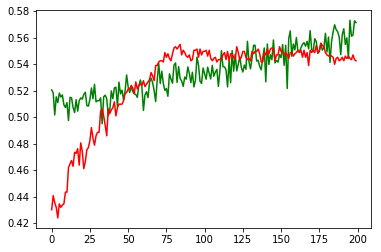

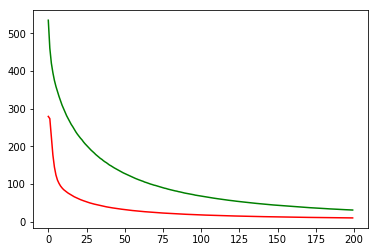

F1,score 0.5637130801687763
G-score: 0.5432600656553424
Accuracy 0.5424778757897099
Window: 140
[[279 227]
 [290 334]]
Vol pos 3.8290283477998073
Vol neg 2.397570686461866
Real Percentage of gain: 10.009951232933606
Percentage of gain: 0.9802215330092896
Total gain: 1107.6503323004972
000000000000000000000000000000000000000000000000
Percentile:  0
[[218 160]
 [213 162]]
753/753 [==============================] - 0s 65us/step
[2.8882419860378836, 0.5046480746066586]
Percentile:  1
[[27 41]
 [49 35]]
152/152 [==============================] - 0s 53us/step
[2.617909883197985, 0.4078947376263769]
Percentile:  2
[[34 26]
 [24 55]]
139/139 [==============================] - 0s 51us/step
[3.556751205766801, 0.6402877714994143]
Percentile:  3
[[ 0  0]
 [ 3 46]]
49/49 [==============================] - 0s 260us/step
[3.037318156690014, 0.938775511420503]
Percentile:  4
[[35]]
35/35 [==============================] - 0s 115us/step
[3.7051304612840923, 1.0]
000000000000000000000000000000000000000

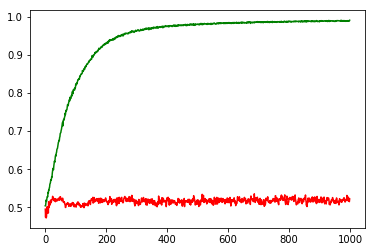

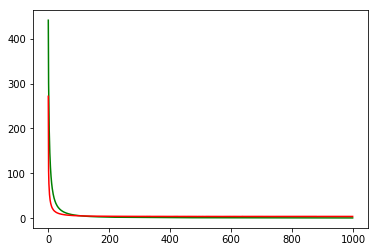

working on d,u and l,le 0.5 512 0.01 1e-05


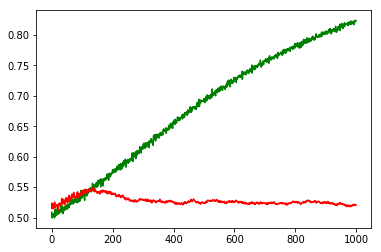

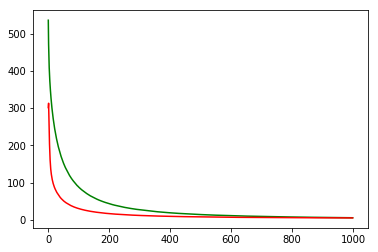

working on d,u and l,le 0.5 756 0.01 0.0001


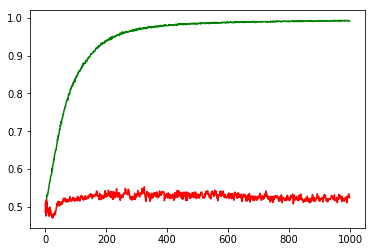

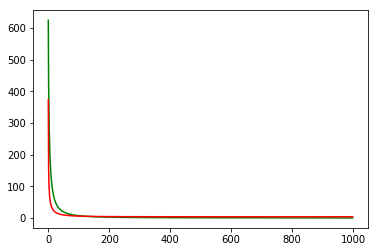

working on d,u and l,le 0.5 756 0.01 1e-05


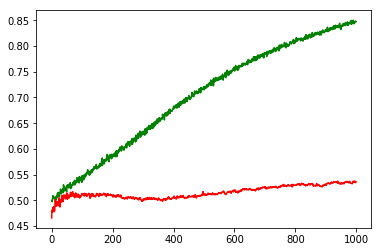

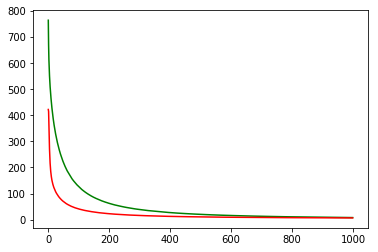

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: AMZN


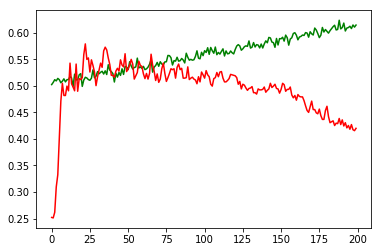

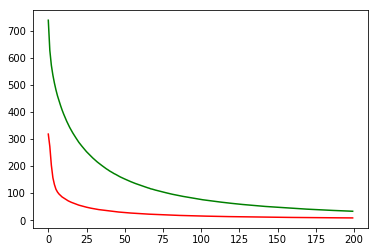

F1,score 0.49460708782742674
G-score: 0.4730800998525451
Accuracy 0.41998231600703234
Window: 140
[[154  97]
 [559 321]]
Vol pos 2.3667017844667995
Vol neg 2.355130526343787
Real Percentage of gain: -64.57866851038564
Percentage of gain: -0.37204445416427456
Total gain: -420.78227765979454
000000000000000000000000000000000000000000000000
Percentile:  0
[[106  93]
 [281 150]]
630/630 [==============================] - 0s 74us/step
[2.6019583028460307, 0.40634920615998527]
Percentile:  1
[[ 33   3]
 [220 129]]
385/385 [==============================] - 0s 82us/step
[2.6630264498970724, 0.42077922077922075]
Percentile:  2
[[15  1]
 [26 33]]
75/75 [==============================] - 0s 160us/step
[3.110579767227173, 0.6400000019868215]
Percentile:  3
[[ 0  0]
 [24  9]]
33/33 [==============================] - 0s 202us/step
[2.5900558630625405, 0.2727272727272727]
Percentile:  4
[[0 0]
 [6 0]]
6/6 [==============================] - 0s 293us/step
[1.0287911891937256, 0.0]
00000000000000000000

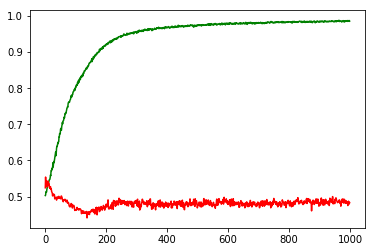

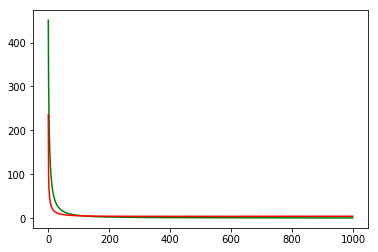

working on d,u and l,le 0.5 512 0.01 1e-05


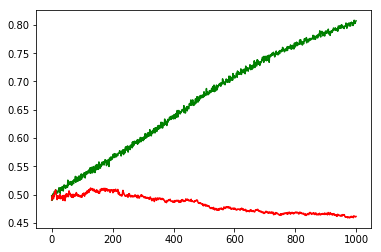

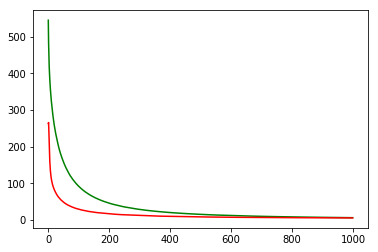

working on d,u and l,le 0.5 756 0.01 0.0001


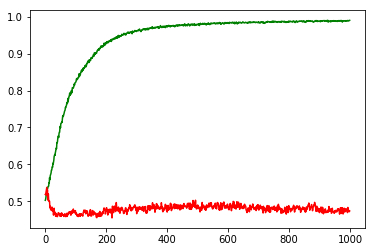

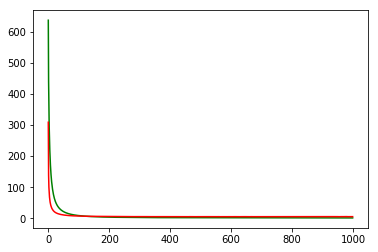

working on d,u and l,le 0.5 756 0.01 1e-05


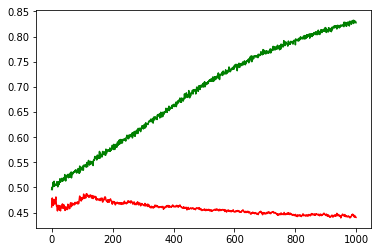

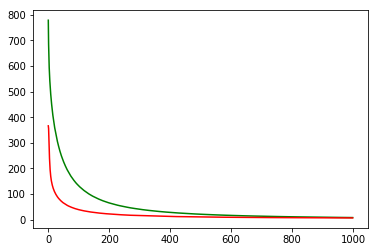

maxd,maxu,maxl,maxle: 0.5 512 0.01 0.0001
Chart for BEST MODEL FOR: GOOGL


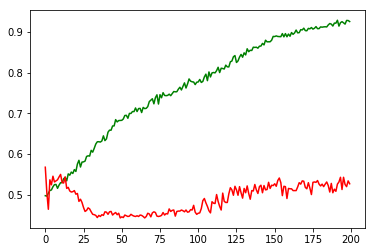

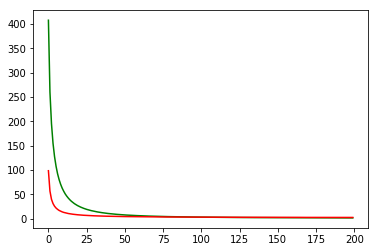

F1,score 0.5407725321888412
G-score: 0.5358913016456669
Accuracy 0.5265486730938465
Window: 140
[[280 175]
 [360 315]]
Vol pos 2.8081155529859343
Vol neg 3.1189748288818824
Real Percentage of gain: -0.024981094710844025
Percentage of gain: 0.0019267438715255554
Total gain: 2.1772205748238775
000000000000000000000000000000000000000000000000
Percentile:  0
[[138  94]
 [ 79 100]]
411/411 [==============================] - 0s 56us/step
[1.6158731821969767, 0.5790754256457308]
Percentile:  1
[[ 74  37]
 [139 113]]
363/363 [==============================] - 0s 51us/step
[1.5911392938992208, 0.515151514987315]
Percentile:  2
[[57 40]
 [68 41]]
206/206 [==============================] - 0s 58us/step
[1.5325369869621055, 0.475728155556813]
Percentile:  3
[[10  4]
 [48 39]]
101/101 [==============================] - 0s 54us/step
[1.3496956813453447, 0.48514851485148514]
Percentile:  4
[[ 0  0]
 [25 22]]
47/47 [==============================] - 0s 62us/step
[1.241547555365461, 0.4680851076511627]

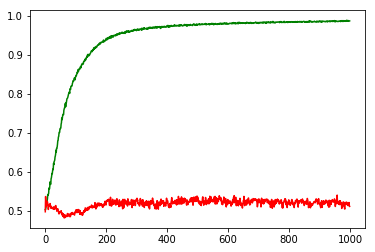

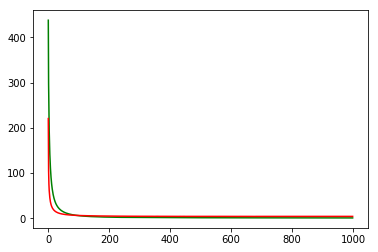

working on d,u and l,le 0.5 512 0.01 1e-05


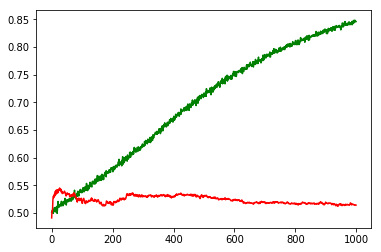

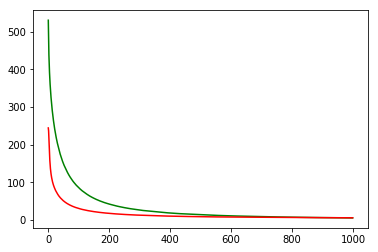

working on d,u and l,le 0.5 756 0.01 0.0001


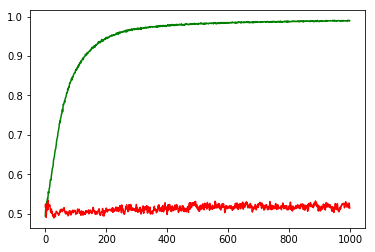

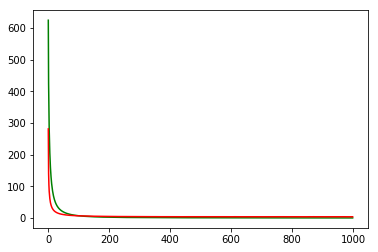

working on d,u and l,le 0.5 756 0.01 1e-05


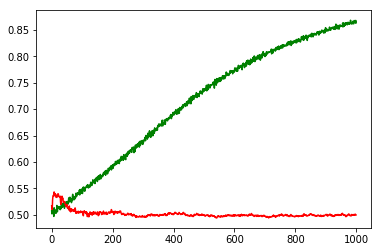

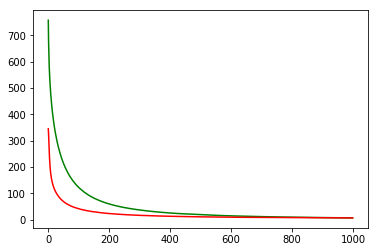

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: MSFT


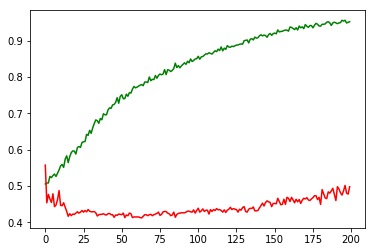

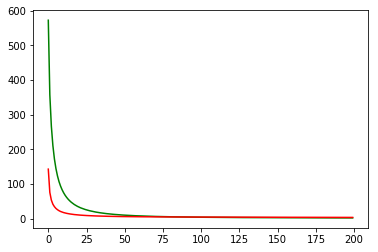

F1,score 0.5116279069767441
G-score: 0.51496442876119
Accuracy 0.49823008786260553
Window: 140
[[266 153]
 [414 297]]
Vol pos 1.4943110747262534
Vol neg 1.655339185945636
Real Percentage of gain: -11.20162267387247
Percentage of gain: -0.08608865784096896
Total gain: -97.28018336029493
000000000000000000000000000000000000000000000000
Percentile:  0
[[185 107]
 [137 115]]
544/544 [==============================] - 0s 72us/step
[1.5193004713338965, 0.5514705882352942]
Percentile:  1
[[ 49  25]
 [153  86]]
313/313 [==============================] - 0s 68us/step
[2.33271605366716, 0.4313099060576564]
Percentile:  2
[[13 10]
 [75 65]]
163/163 [==============================] - 0s 101us/step
[2.116924790516953, 0.4785276073619632]
Percentile:  3
[[14  6]
 [36 25]]
81/81 [==============================] - 0s 117us/step
[1.5285656422744562, 0.4814814829532011]
Percentile:  4
[[ 5  5]
 [13  5]]
28/28 [==============================] - 0s 83us/step
[2.410355567932129, 0.3571428656578064]
0000000

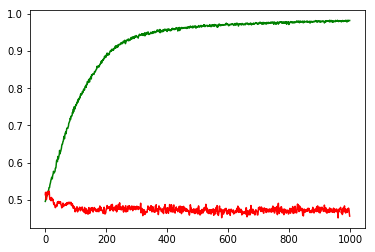

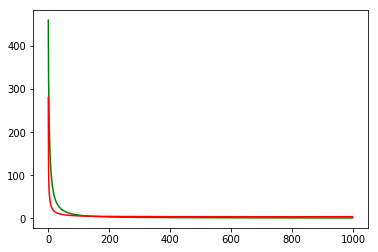

working on d,u and l,le 0.5 512 0.01 1e-05


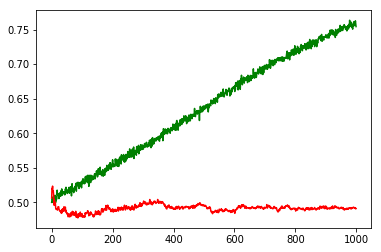

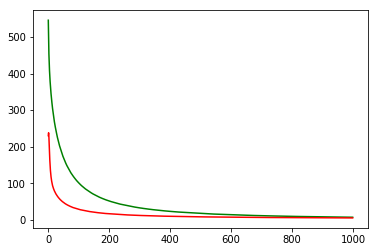

working on d,u and l,le 0.5 756 0.01 0.0001


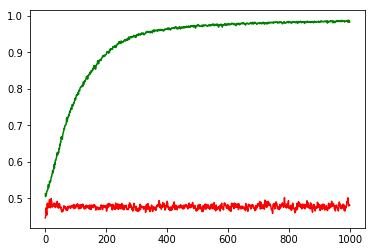

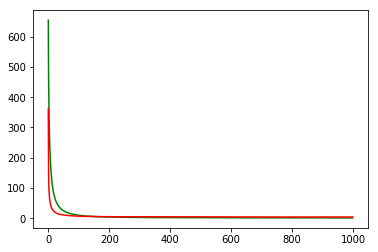

working on d,u and l,le 0.5 756 0.01 1e-05


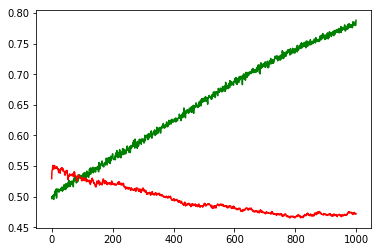

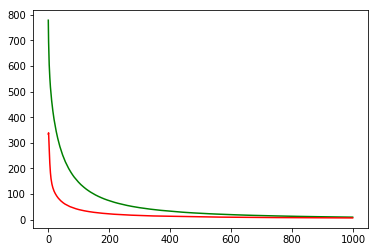

maxd,maxu,maxl,maxle: 0.5 512 0.01 1e-05
Chart for BEST MODEL FOR: FB


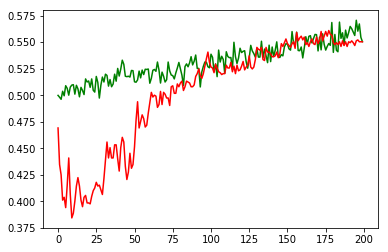

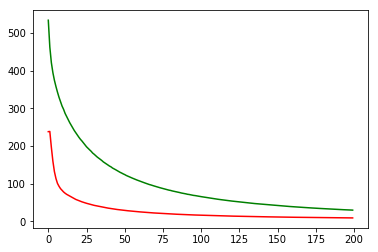

F1,score 0.6631369953673064
G-score: 0.5171434350012543
Accuracy 0.5503533559426823
Window: 140
[[122 141]
 [368 501]]
Vol pos 2.8290530342163542
Vol neg 3.381968878707536
Real Percentage of gain: 43.102031475548316
Percentage of gain: 0.03628788079032936
Total gain: 41.077881054652835
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 96 116]
 [115 195]]
522/522 [==============================] - 0s 64us/step
[2.6871976208412782, 0.5574712645961863]
Percentile:  1
[[ 18  19]
 [166 265]]
468/468 [==============================] - 0s 80us/step
[3.1107310800470858, 0.6047008547008547]
Percentile:  2
[[ 8  5]
 [56 36]]
105/105 [==============================] - 0s 76us/step
[2.947478743961879, 0.41904761904761906]
Percentile:  3
[[ 0  0]
 [13  1]]
14/14 [==============================] - 0s 150us/step
[1.464322805404663, 0.0714285746216774]
Percentile:  4
[[ 0  0]
 [17  4]]
21/21 [==============================] - 0s 69us/step
[2.098450183868408, 0.190476194024086]
0000000

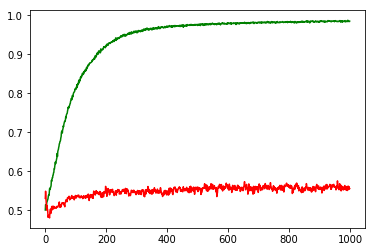

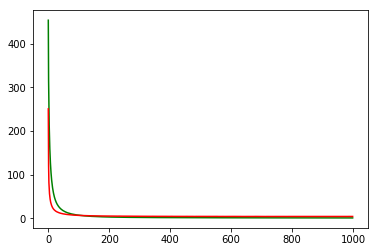

working on d,u and l,le 0.5 512 0.01 1e-05


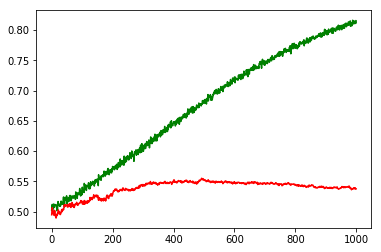

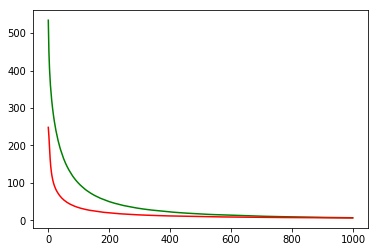

working on d,u and l,le 0.5 756 0.01 0.0001


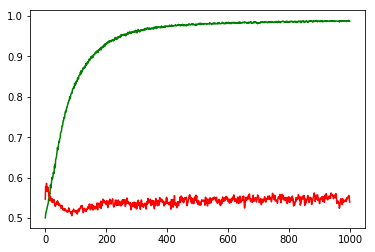

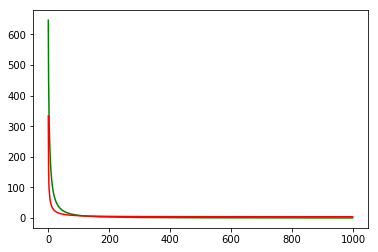

working on d,u and l,le 0.5 756 0.01 1e-05


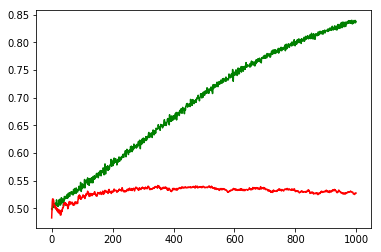

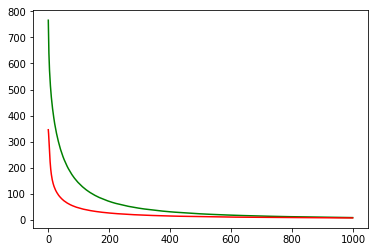

maxd,maxu,maxl,maxle: 0.5 512 0.01 0.0001
Chart for BEST MODEL FOR: INTC


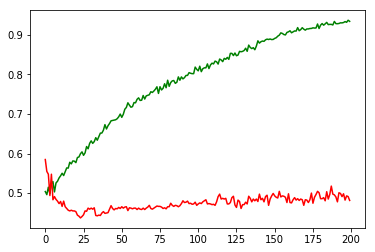

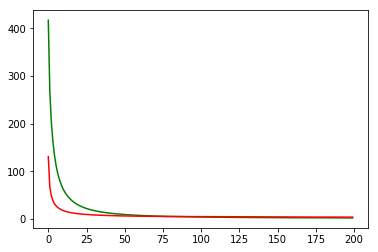

F1,score 0.5254648342764753
G-score: 0.48304318920768685
Accuracy 0.4814487629349577
Window: 140
[[220 228]
 [359 325]]
Vol pos 2.0324194036653624
Vol neg 2.607016314098576
Real Percentage of gain: 1.1719450348732028
Percentage of gain: -0.3733657255991533
Total gain: -422.65000137824154
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 66  50]
 [ 94 144]]
354/354 [==============================] - 0s 60us/step
[1.7293936470470859, 0.5932203389830508]
Percentile:  1
[[ 73  41]
 [121 107]]
342/342 [==============================] - 0s 62us/step
[1.7863675836931194, 0.5263157892994016]
Percentile:  2
[[31 96]
 [88 63]]
278/278 [==============================] - 0s 42us/step
[2.2439554063536282, 0.3381294967244855]
Percentile:  3
[[29 34]
 [42  9]]
114/114 [==============================] - 0s 91us/step
[2.2097780286220083, 0.3333333349018766]
Percentile:  4
[[21  7]
 [13  1]]
42/42 [==============================] - 0s 159us/step
[1.3905377210605712, 0.5238095238095238]


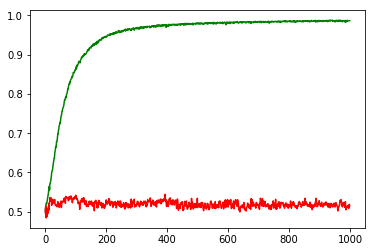

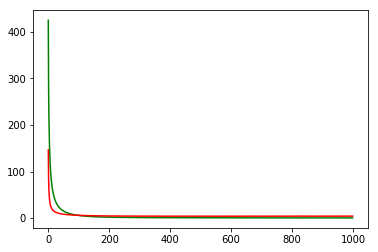

working on d,u and l,le 0.5 512 0.01 1e-05


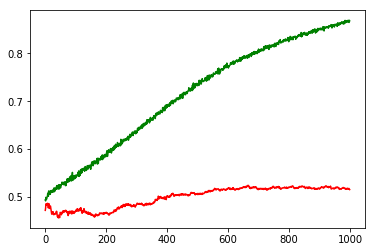

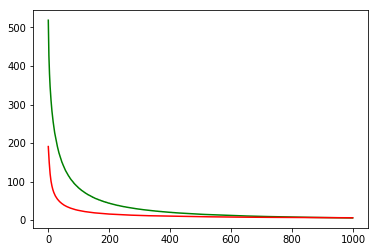

working on d,u and l,le 0.5 756 0.01 0.0001


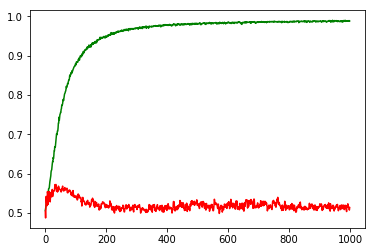

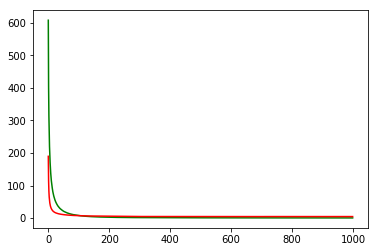

working on d,u and l,le 0.5 756 0.01 1e-05


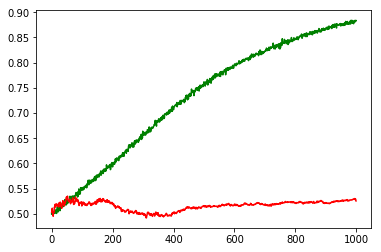

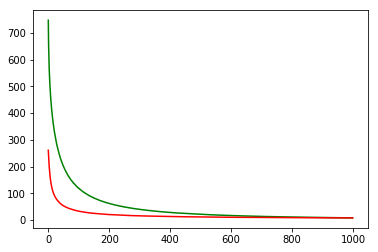

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: CSCO


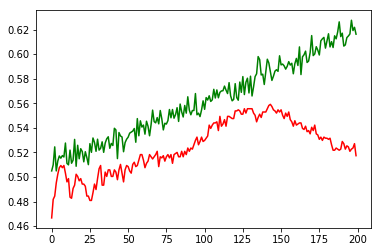

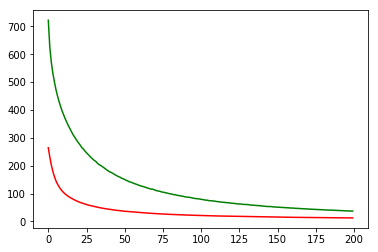

F1,score 0.4104234527687296
G-score: 0.4902081019613115
Accuracy 0.5173333334657881
Window: 140
[[393  84]
 [459 189]]
Vol pos 1.9668765281252951
Vol neg 1.7073552058967263
Real Percentage of gain: 62.876900842025776
Percentage of gain: 0.19344734450399936
Total gain: 217.6282625669993
000000000000000000000000000000000000000000000000
Percentile:  0
[[171  49]
 [218  78]]
516/516 [==============================] - 0s 72us/step
[3.3565577213154283, 0.48255813953488375]
Percentile:  1
[[ 87   9]
 [136  91]]
323/323 [==============================] - 0s 93us/step
[4.1368844776699785, 0.5510835913312694]
Percentile:  2
[[48  2]
 [69 19]]
138/138 [==============================] - 0s 90us/step
[3.8143889955852344, 0.4855072463768116]
Percentile:  3
[[42 16]
 [28  0]]
86/86 [==============================] - 0s 97us/step
[3.264024484989255, 0.4883720930232558]
Percentile:  4
[[44  8]
 [ 6  0]]
58/58 [==============================] - 0s 89us/step
[2.5029146342441955, 0.7586206814338421]
00000

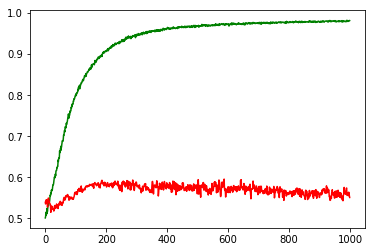

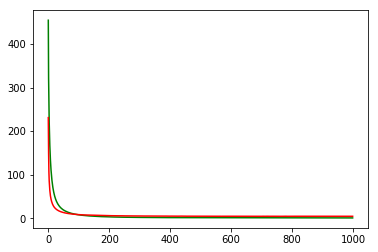

working on d,u and l,le 0.5 512 0.01 1e-05


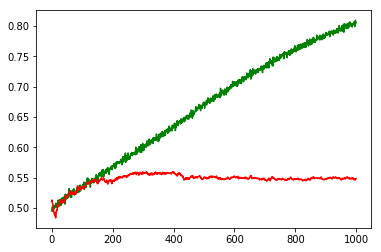

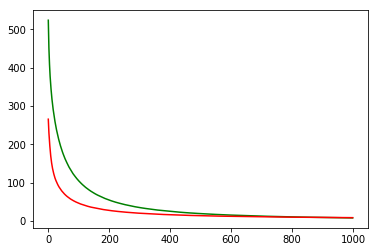

working on d,u and l,le 0.5 756 0.01 0.0001


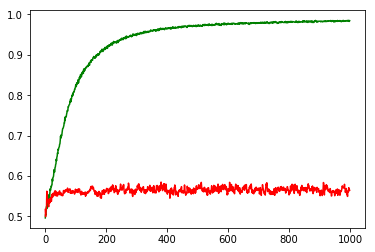

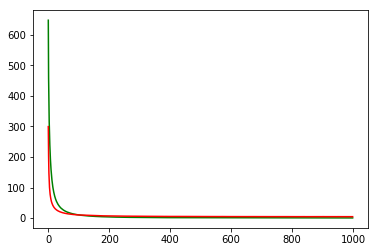

working on d,u and l,le 0.5 756 0.01 1e-05


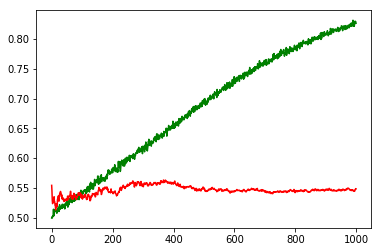

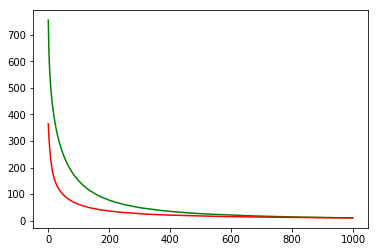

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: CMCSA


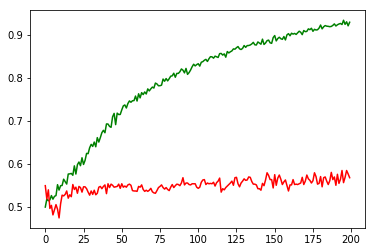

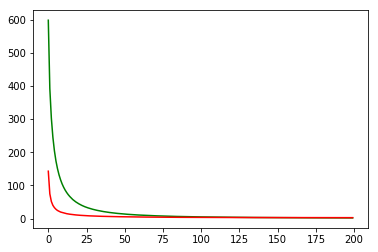

F1,score 0.5914786967418547
G-score: 0.565206639061552
Accuracy 0.5676392595605656
Window: 140
[[288 252]
 [237 354]]
Vol pos 2.9972201058597068
Vol neg 2.675679839585325
Real Percentage of gain: 116.78326267634306
Percentage of gain: 0.5444808721527038
Total gain: 615.807866404708
000000000000000000000000000000000000000000000000
Percentile:  0
[[116 111]
 [ 82 118]]
427/427 [==============================] - 0s 71us/step
[1.6078824164995824, 0.5480093675419095]
Percentile:  1
[[ 98  99]
 [115 189]]
501/501 [==============================] - 0s 73us/step
[1.6028385399701353, 0.572854291893051]
Percentile:  2
[[14 28]
 [30 44]]
116/116 [==============================] - 0s 84us/step
[1.8159818289608791, 0.5]
Percentile:  3
[[46 14]
 [ 9  3]]
72/72 [==============================] - 0s 99us/step
[1.167478322982788, 0.6805555555555556]
Percentile:  4
[[13]]
13/13 [==============================] - 0s 142us/step
[0.2127196341753006, 1.0]
000000000000000000000000000000000000000000000000
Wor

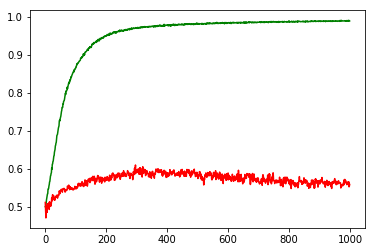

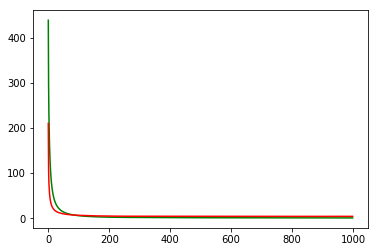

working on d,u and l,le 0.5 512 0.01 1e-05


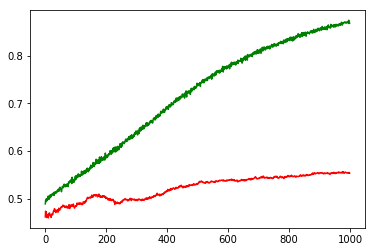

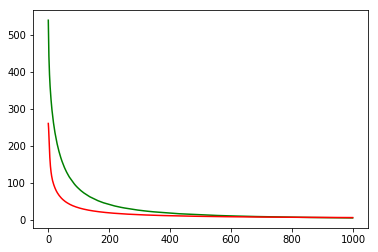

working on d,u and l,le 0.5 756 0.01 0.0001


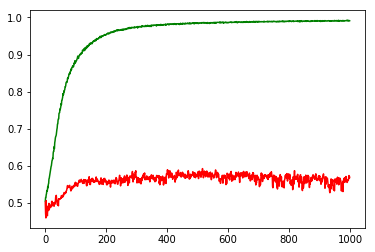

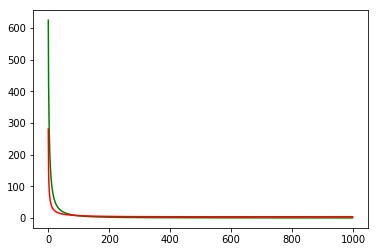

working on d,u and l,le 0.5 756 0.01 1e-05


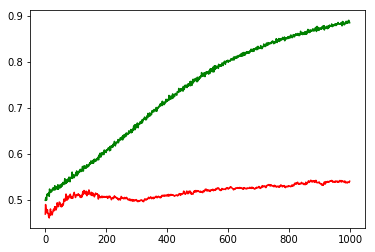

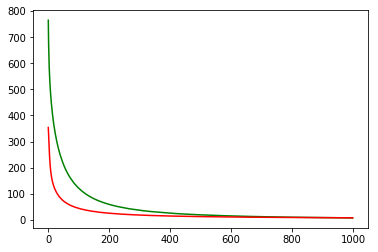

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: NVDA


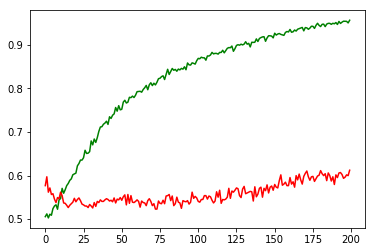

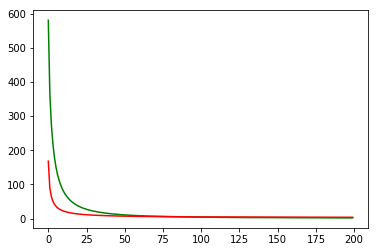

F1,score 0.6572989851678377
G-score: 0.6055780203045337
Accuracy 0.6121908141951679
Window: 140
[[272 204]
 [235 421]]
Vol pos 4.025774527036914
Vol neg 3.3656231495909883
Real Percentage of gain: 248.9126603554395
Percentage of gain: 1.1593226012068354
Total gain: 1312.3531845661375
000000000000000000000000000000000000000000000000
Percentile:  0
[[177 136]
 [ 90 156]]
559/559 [==============================] - 0s 73us/step
[1.8591958164955507, 0.5957066197088238]
Percentile:  1
[[ 66  51]
 [ 86 134]]
337/337 [==============================] - 0s 75us/step
[1.9276932877673594, 0.5934718100890207]
Percentile:  2
[[22  9]
 [33 39]]
103/103 [==============================] - 0s 87us/step
[1.7795416544942022, 0.5922330097087378]
Percentile:  3
[[ 7  8]
 [15 50]]
80/80 [==============================] - 0s 86us/step
[2.3265985369682314, 0.7125]
Percentile:  4
[[ 0  0]
 [10 41]]
51/51 [==============================] - 0s 122us/step
[1.2389244846269196, 0.8039215756397621]
000000000000000000

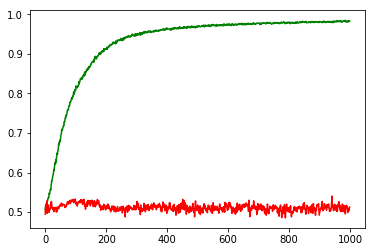

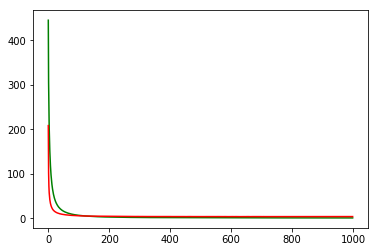

working on d,u and l,le 0.5 512 0.01 1e-05


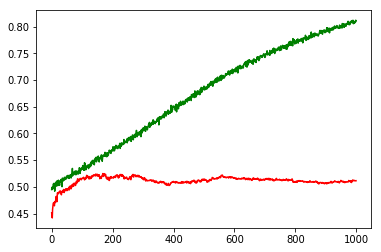

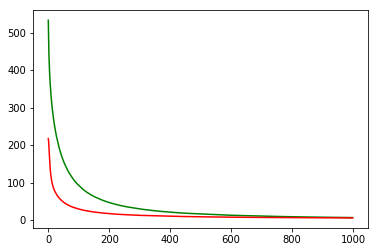

working on d,u and l,le 0.5 756 0.01 0.0001


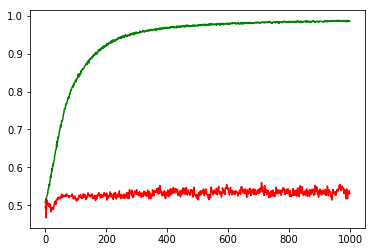

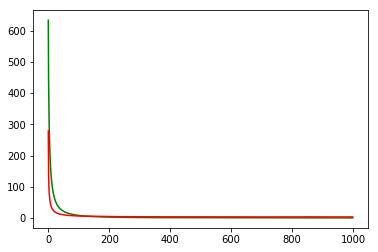

working on d,u and l,le 0.5 756 0.01 1e-05


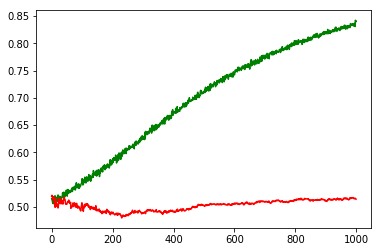

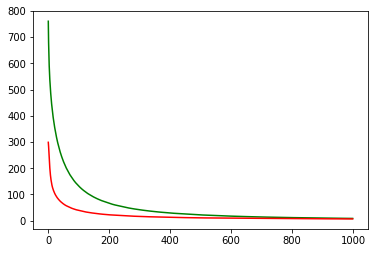

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: NFLX


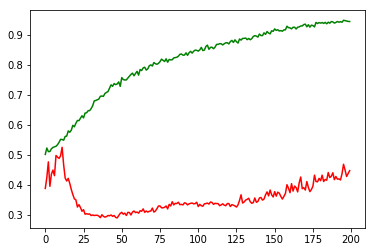

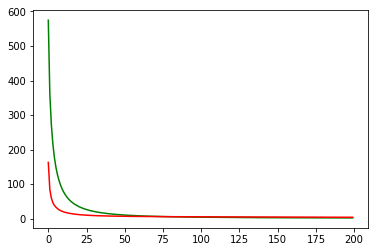

F1,score 0.5283018867924528
G-score: 0.469499432196243
Accuracy 0.4473916893770587
Window: 140
[[156 141]
 [484 350]]
Vol pos 4.552174913361848
Vol neg 4.163682545143739
Real Percentage of gain: -99.69546262694026
Percentage of gain: -0.26428035769561614
Total gain: -298.90108455374184
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 76  94]
 [184 106]]
460/460 [==============================] - 0s 76us/step
[1.9967098319012186, 0.39565217391304347]
Percentile:  1
[[ 29  31]
 [139 128]]
327/327 [==============================] - 0s 78us/step
[2.1250427585858453, 0.48012232425016]
Percentile:  2
[[ 29   9]
 [115  80]]
233/233 [==============================] - 0s 83us/step
[2.2801796622542354, 0.4678111587982833]
Percentile:  3
[[21  6]
 [41 29]]
97/97 [==============================] - 0s 88us/step
[1.6386679361775978, 0.5154639175257731]
Percentile:  4
[[1 0]
 [5 6]]
12/12 [==============================] - 0s 180us/step
[0.8834322094917297, 0.5833333134651184]
00000

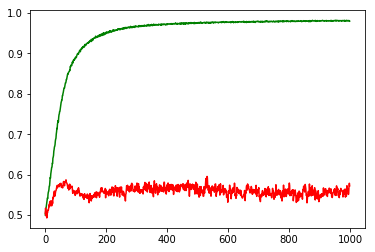

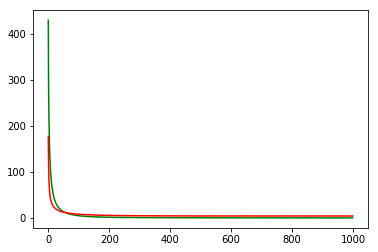

working on d,u and l,le 0.5 512 0.01 1e-05


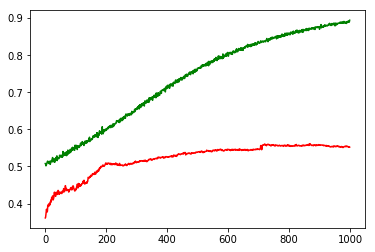

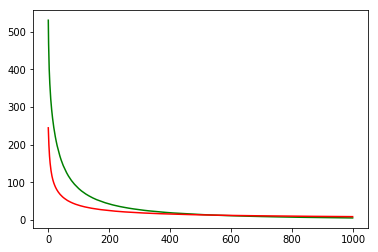

working on d,u and l,le 0.5 756 0.01 0.0001


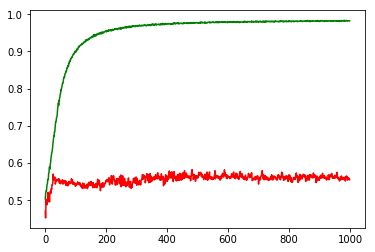

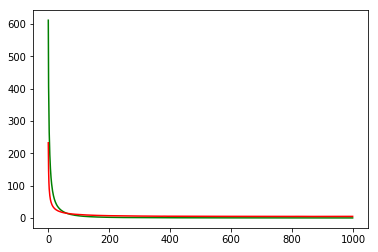

working on d,u and l,le 0.5 756 0.01 1e-05


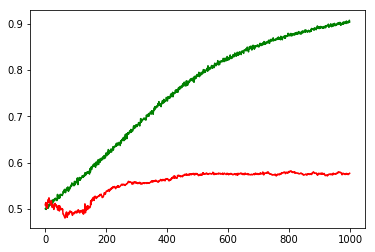

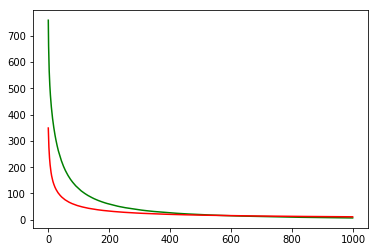

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: ADBE


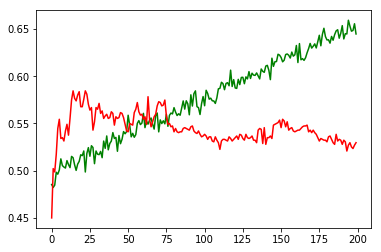

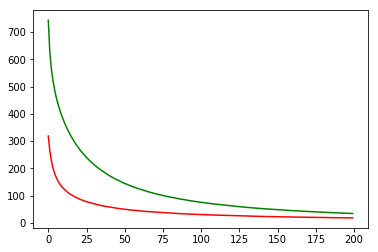

F1,score 0.6069578090303479
G-score: 0.5177807332633921
Accuracy 0.5296722768522977
Window: 140
[[188 200]
 [331 410]]
Vol pos 2.771530504967228
Vol neg 2.4140467038836686
Real Percentage of gain: 48.58148795563906
Percentage of gain: 0.3326097805209691
Total gain: 375.5164422081741
000000000000000000000000000000000000000000000000
Percentile:  0
[[119 158]
 [127 157]]
561/561 [==============================] - 0s 74us/step
[5.504544780003621, 0.4919786096256685]
Percentile:  1
[[ 21  42]
 [119 142]]
324/324 [==============================] - 0s 81us/step
[4.914094129462301, 0.5030864197530864]
Percentile:  2
[[25  0]
 [53 80]]
158/158 [==============================] - 0s 67us/step
[4.096348853050908, 0.6645569650432731]
Percentile:  3
[[23  0]
 [16 27]]
66/66 [==============================] - 0s 117us/step
[5.620111006678957, 0.7575757575757576]
Percentile:  4
[[ 0  0]
 [14  4]]
18/18 [==============================] - 0s 104us/step
[2.98563551902771, 0.2222222238779068]
000000000000

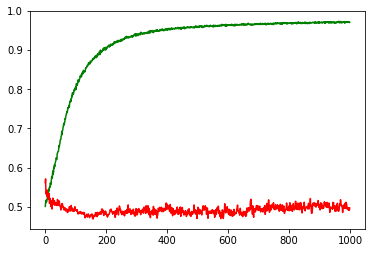

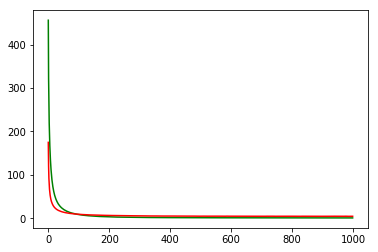

working on d,u and l,le 0.5 512 0.01 1e-05


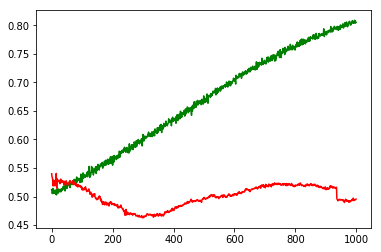

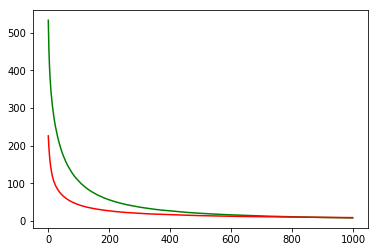

working on d,u and l,le 0.5 756 0.01 0.0001


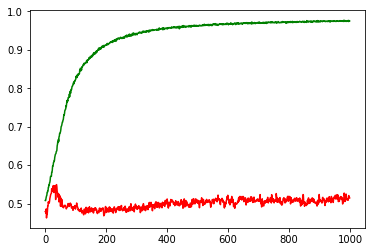

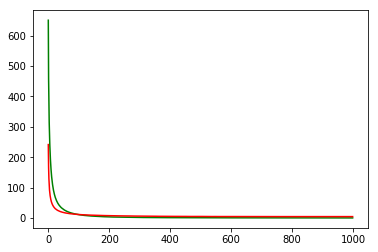

working on d,u and l,le 0.5 756 0.01 1e-05


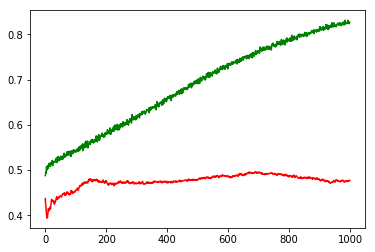

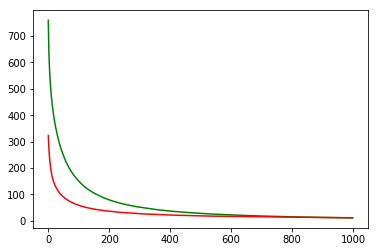

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: AMGN


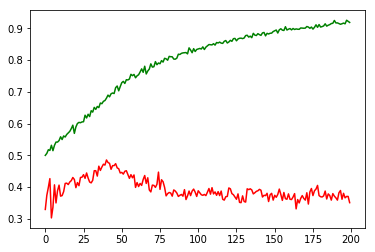

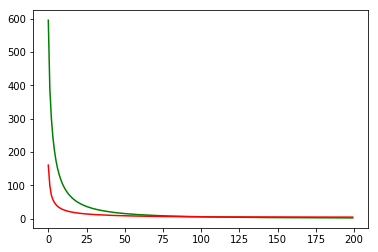

F1,score 0.35429583702391493
G-score: 0.38858237737957524
Accuracy 0.3508459472645635
Window: 140
[[194 126]
 [603 200]]
Vol pos 1.747247512064368
Vol neg 2.030691544332576
Real Percentage of gain: -190.9850853910827
Percentage of gain: -0.7052169332725619
Total gain: -791.958616065087
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 98  67]
 [196  85]]
446/446 [==============================] - 0s 83us/step
[2.5100530744133507, 0.41031390154575553]
Percentile:  1
[[ 50   5]
 [208  53]]
316/316 [==============================] - 0s 76us/step
[2.3694569068618967, 0.32594936784309675]
Percentile:  2
[[ 19   7]
 [147  41]]
214/214 [==============================] - 0s 75us/step
[2.8979036785731807, 0.28037383205422733]
Percentile:  3
[[19 37]
 [49 20]]
125/125 [==============================] - 0s 83us/step
[2.625807891845703, 0.3120000014305115]
Percentile:  4
[[ 7 10]
 [ 3  0]]
20/20 [==============================] - 0s 87us/step
[1.994823694229126, 0.3499999940395355

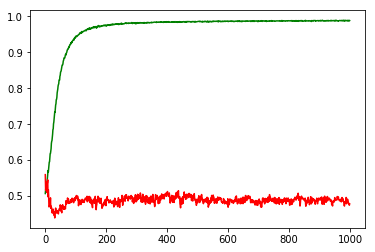

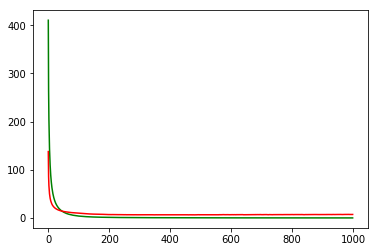

working on d,u and l,le 0.5 512 0.01 1e-05


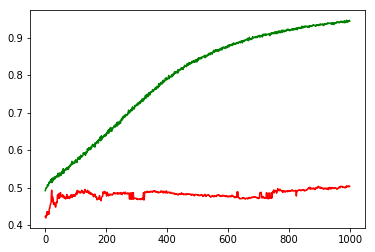

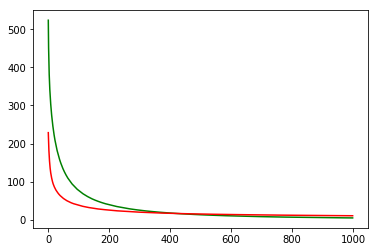

working on d,u and l,le 0.5 756 0.01 0.0001


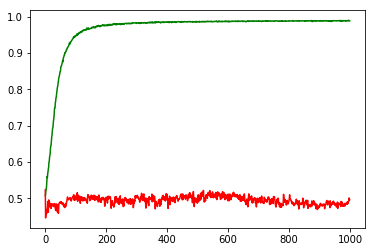

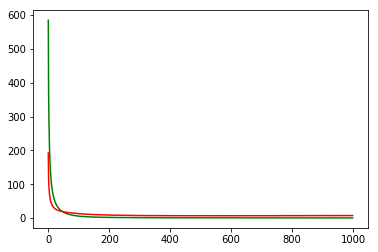

working on d,u and l,le 0.5 756 0.01 1e-05


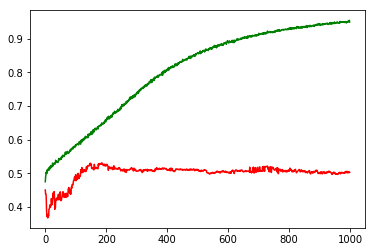

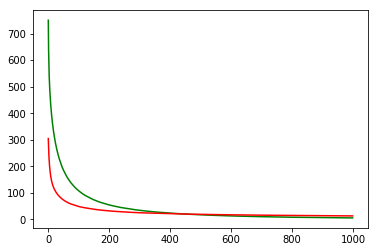

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: TXN


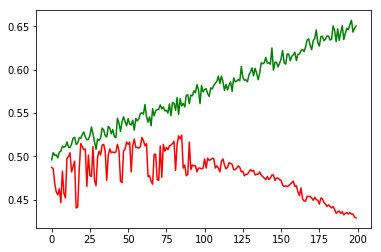

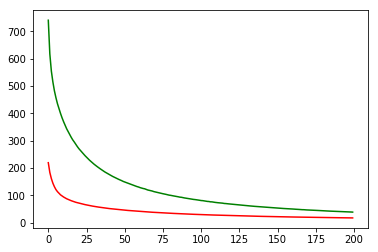

F1,score 0.48566878980891715
G-score: 0.4421809148745416
Accuracy 0.42882404930290136
Window: 140
[[180 188]
 [458 305]]
Vol pos 2.4977144278480123
Vol neg 2.49444025612217
Real Percentage of gain: -97.94406055426688
Percentage of gain: -0.3536842687432678
Total gain: -400.0169079486359
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 87 121]
 [137 110]]
455/455 [==============================] - 0s 75us/step
[4.7460655154762685, 0.4329670330652824]
Percentile:  1
[[ 65  64]
 [112  93]]
334/334 [==============================] - 0s 75us/step
[5.000455088244227, 0.47305389221556887]
Percentile:  2
[[ 12   2]
 [133  45]]
192/192 [==============================] - 0s 70us/step
[4.9255101680755615, 0.296875]
Percentile:  3
[[ 9  1]
 [65 47]]
122/122 [==============================] - 0s 86us/step
[4.333892603389552, 0.4590163944197483]
Percentile:  4
[[ 7  0]
 [11  8]]
26/26 [==============================] - 0s 70us/step
[3.675433874130249, 0.5769230723381042]
0000000000

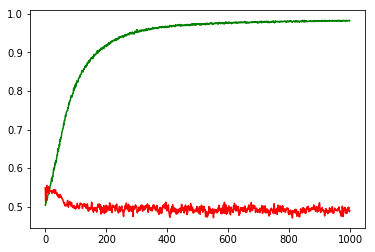

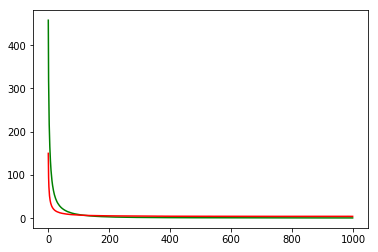

working on d,u and l,le 0.5 512 0.01 1e-05


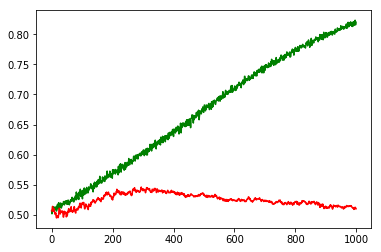

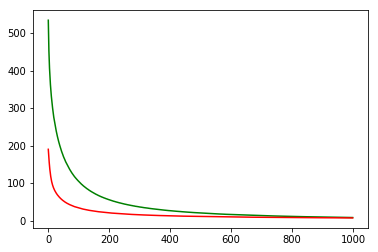

working on d,u and l,le 0.5 756 0.01 0.0001


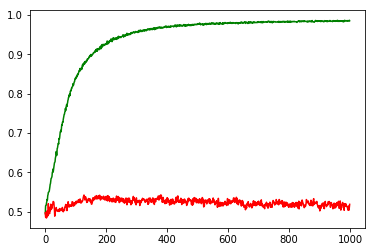

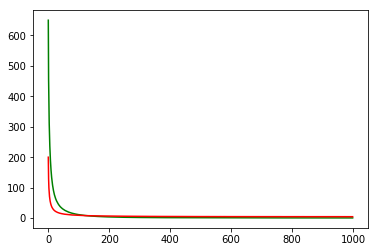

working on d,u and l,le 0.5 756 0.01 1e-05


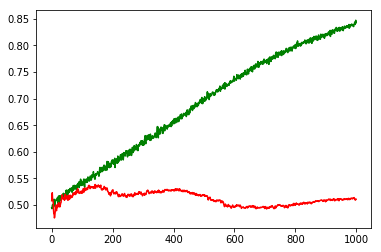

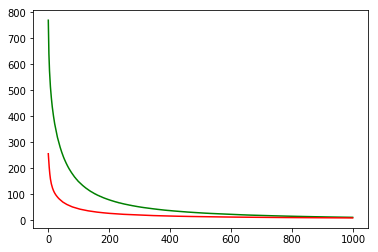

maxd,maxu,maxl,maxle: 0.5 756 0.01 0.0001
Chart for BEST MODEL FOR: AVGO


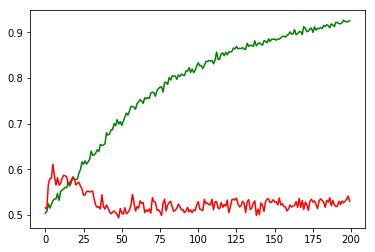

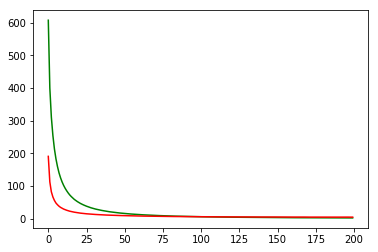

F1,score 0.5709651257096513
G-score: 0.5434495455937166
Accuracy 0.5301953819092383
Window: 140
[[245 160]
 [369 352]]
Vol pos 3.2924675641906163
Vol neg 3.0966063325116235
Real Percentage of gain: 24.43485529874654
Percentage of gain: 0.29085114202766343
Total gain: 327.49838592314904
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 80 121]
 [110 164]]
475/475 [==============================] - 0s 78us/step
[2.381608567990755, 0.5136842102126071]
Percentile:  1
[[79 25]
 [87 63]]
254/254 [==============================] - 0s 73us/step
[2.1381416095523385, 0.5590551185208982]
Percentile:  2
[[ 32   5]
 [121 101]]
259/259 [==============================] - 0s 79us/step
[2.93651228061514, 0.5135135135135135]
Percentile:  3
[[21  4]
 [42 21]]
88/88 [==============================] - 0s 86us/step
[2.8979940847917036, 0.4772727272727273]
Percentile:  4
[[32  5]
 [ 9  2]]
48/48 [==============================] - 0s 84us/step
[1.6326209704081218, 0.7083333333333334]
00000000

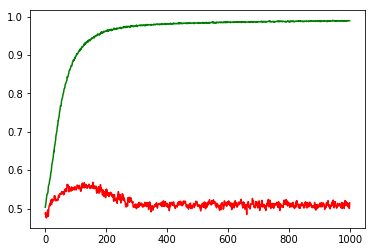

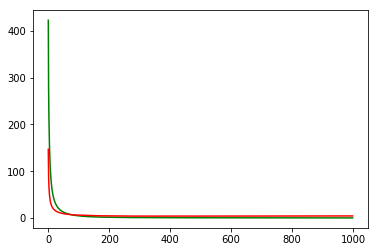

working on d,u and l,le 0.5 512 0.01 1e-05


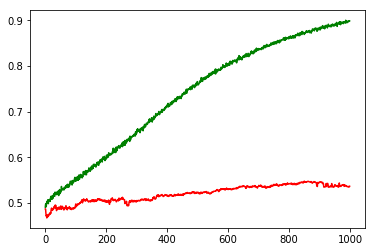

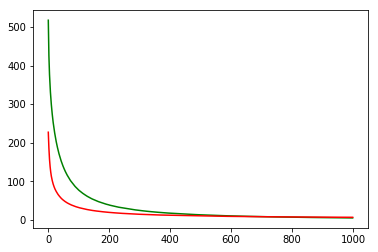

working on d,u and l,le 0.5 756 0.01 0.0001


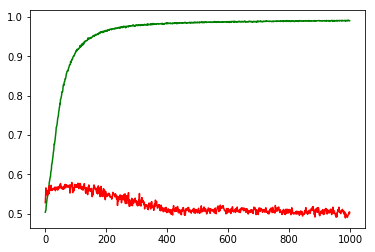

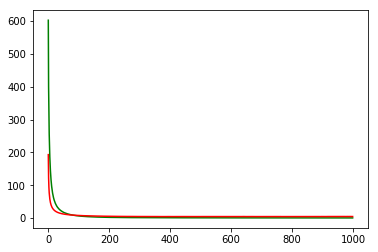

working on d,u and l,le 0.5 756 0.01 1e-05


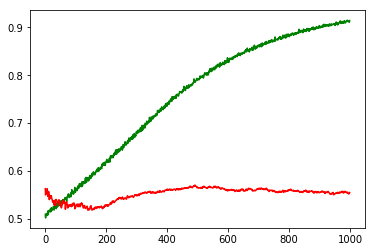

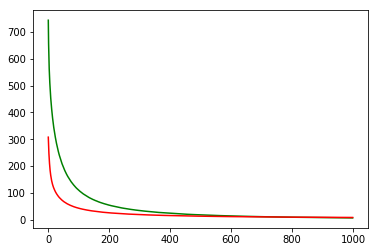

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: PYPL


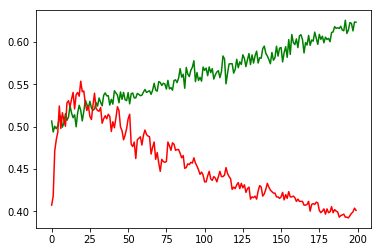

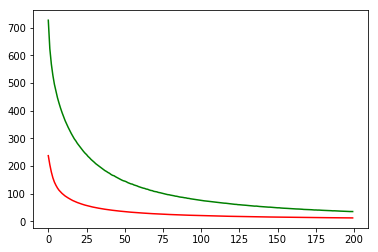

F1,score 0.4251700680272109
G-score: 0.44360255226444345
Accuracy 0.40124003593112856
Window: 140
[[203 115]
 [561 250]]
Vol pos 2.767562998923877
Vol neg 3.005270166974258
Real Percentage of gain: -74.0386191354231
Percentage of gain: -0.6889783829602145
Total gain: -777.8565943620822
000000000000000000000000000000000000000000000000
Percentile:  0
[[102  32]
 [311 134]]
579/579 [==============================] - 0s 72us/step
[3.8645145823094924, 0.40759930920518533]
Percentile:  1
[[ 24  27]
 [165  92]]
308/308 [==============================] - 0s 75us/step
[3.7548541511808122, 0.37662337584929034]
Percentile:  2
[[67 53]
 [40 24]]
184/184 [==============================] - 0s 82us/step
[3.6701080799102783, 0.4945652173913043]
Percentile:  3
[[10  3]
 [30  0]]
43/43 [==============================] - 0s 105us/step
[3.392807508623877, 0.23255813953488372]
Percentile:  4
[[ 0  0]
 [12  0]]
12/12 [==============================] - 0s 132us/step
[1.6963574886322021, 0.0]
0000000000000000

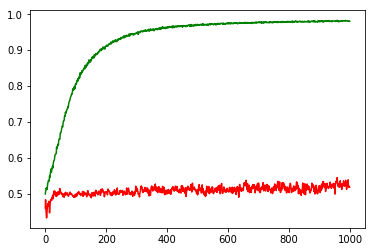

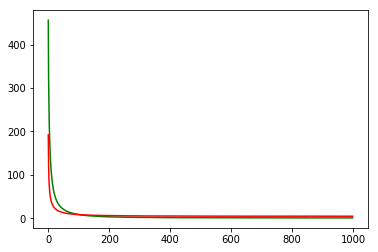

working on d,u and l,le 0.5 512 0.01 1e-05


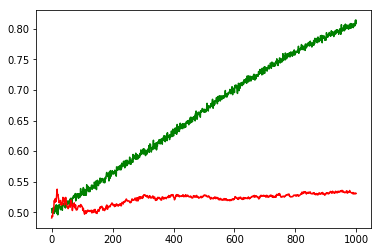

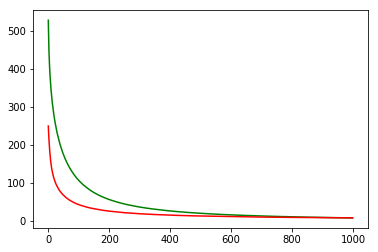

working on d,u and l,le 0.5 756 0.01 0.0001


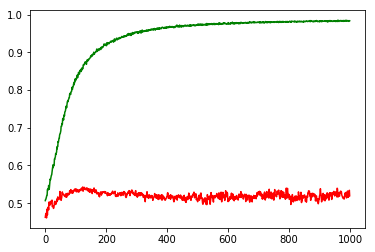

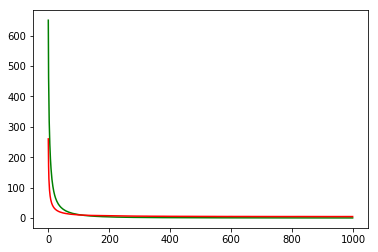

working on d,u and l,le 0.5 756 0.01 1e-05


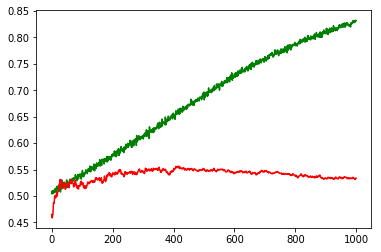

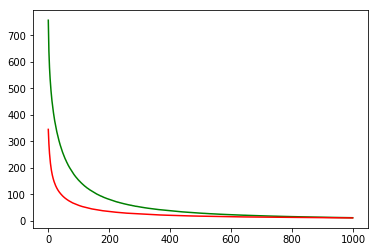

maxd,maxu,maxl,maxle: 0.5 756 0.01 1e-05
Chart for BEST MODEL FOR: GILD


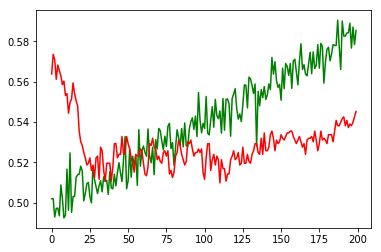

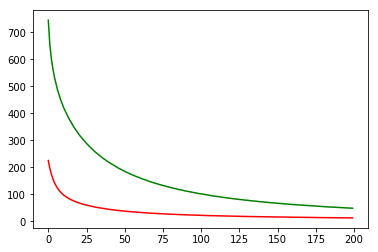

F1,score 0.5678180286436395
G-score: 0.542974625839901
Accuracy 0.5452127663801748
Window: 140
[[278 304]
 [209 337]]
Vol pos 3.4820667882649325
Vol neg 2.9473255719981104
Real Percentage of gain: 98.54508755824696
Percentage of gain: 0.5580612201665806
Total gain: 629.4930563479029
000000000000000000000000000000000000000000000000
Percentile:  0
[[132 207]
 [ 99 170]]
608/608 [==============================] - 0s 72us/step
[3.8588046651137504, 0.4967105263157895]
Percentile:  1
[[ 69  34]
 [ 84 120]]
307/307 [==============================] - 0s 68us/step
[3.841591830362326, 0.6156351783764867]
Percentile:  2
[[ 3  9]
 [26 44]]
82/82 [==============================] - 0s 95us/step
[4.455595894557674, 0.5731707302535453]
Percentile:  3
[[10 31]
 [ 0  0]]
41/41 [==============================] - 0s 117us/step
[3.881094397568121, 0.24390243902439024]
Percentile:  4
[[63 23]
 [ 0  0]]
86/86 [==============================] - 0s 81us/step
[2.8445901704388996, 0.7325581409210382]
00000000000

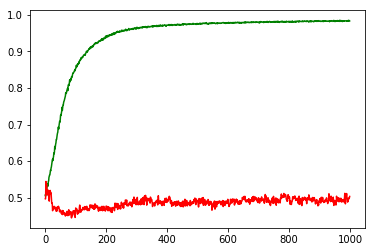

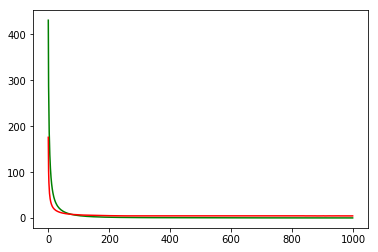

working on d,u and l,le 0.5 512 0.01 1e-05


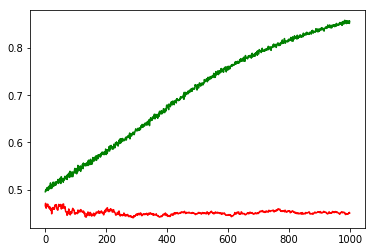

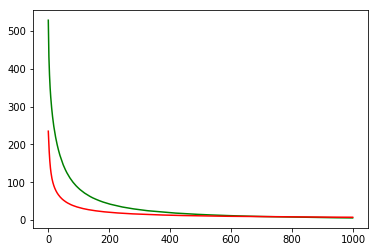

working on d,u and l,le 0.5 756 0.01 0.0001


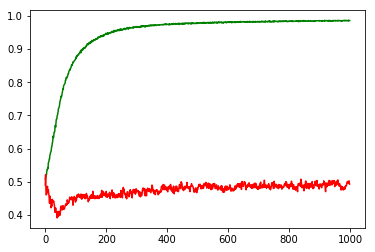

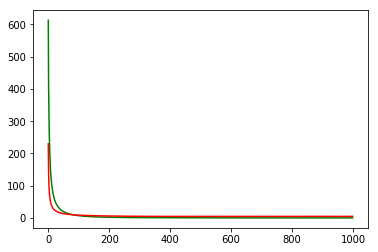

working on d,u and l,le 0.5 756 0.01 1e-05


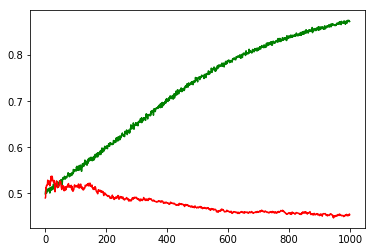

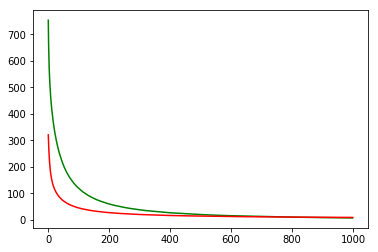

maxd,maxu,maxl,maxle: 0.5 512 0.01 0.0001
Chart for BEST MODEL FOR: COST


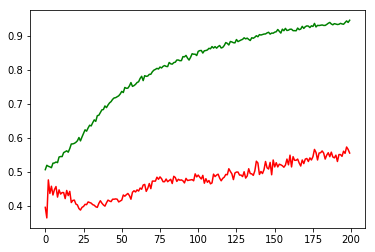

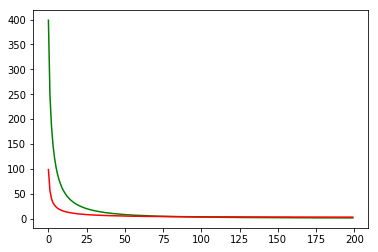

F1,score 0.6224566691785984
G-score: 0.5549227248732386
Accuracy 0.5554569650775263
Window: 140
[[213 172]
 [329 413]]
Vol pos 1.4230434999720283
Vol neg 1.3435937890881715
Real Percentage of gain: 63.30875784503221
Percentage of gain: 0.19315416384145148
Total gain: 217.6847426493158
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 99 101]
 [104  83]]
387/387 [==============================] - 0s 57us/step
[2.0302366411039072, 0.4702842378031068]
Percentile:  1
[[ 70  34]
 [ 89 117]]
310/310 [==============================] - 0s 61us/step
[1.6505935484363188, 0.603225806451613]
Percentile:  2
[[ 40  28]
 [ 67 138]]
273/273 [==============================] - 0s 57us/step
[1.4754585101927593, 0.652014652069235]
Percentile:  3
[[ 3  9]
 [33 47]]
92/92 [==============================] - 0s 81us/step
[1.9331720134486323, 0.543478258278059]
Percentile:  4
[[ 0  0]
 [36 27]]
63/63 [==============================] - 0s 77us/step
[1.686357061068217, 0.4285714351941669]
000000

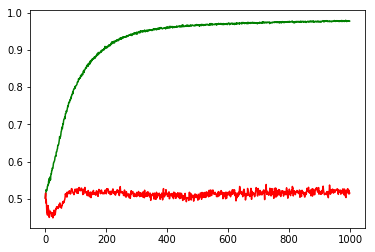

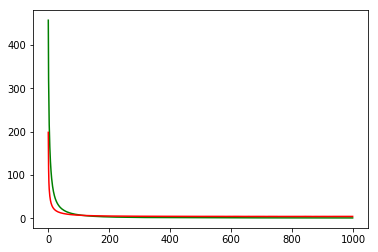

working on d,u and l,le 0.5 512 0.01 1e-05


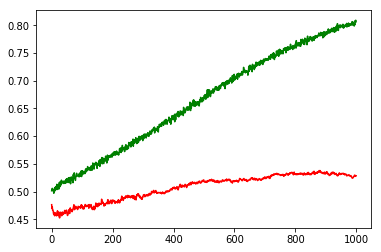

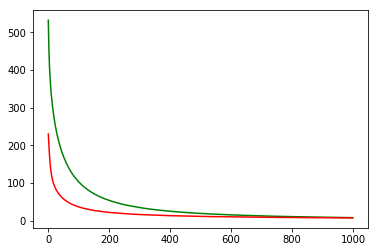

working on d,u and l,le 0.5 756 0.01 0.0001


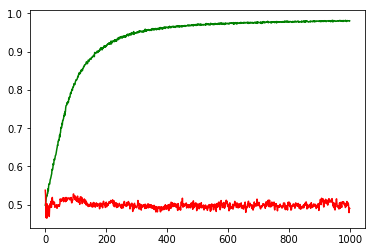

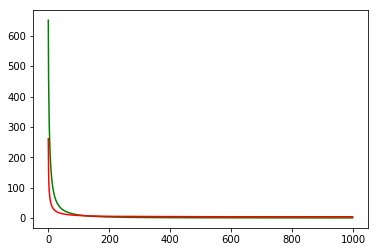

working on d,u and l,le 0.5 756 0.01 1e-05


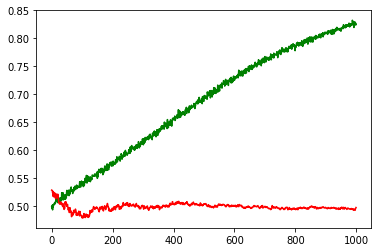

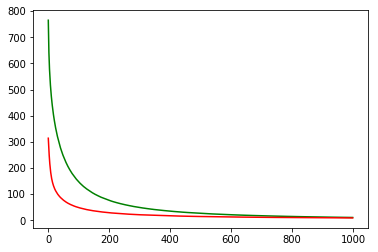

maxd,maxu,maxl,maxle: 0.5 512 0.01 1e-05
Chart for BEST MODEL FOR: QCOM


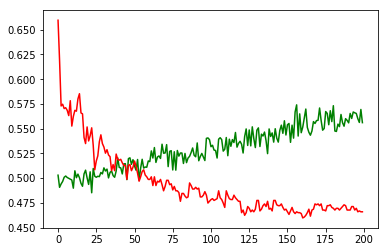

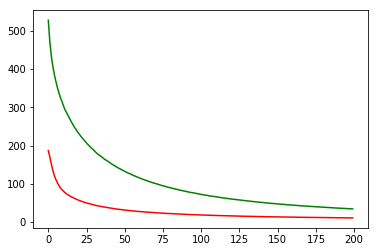

F1,score 0.5505952380952382
G-score: 0.45920398800435064
Accuracy 0.46595932818639607
Window: 140
[[157 198]
 [406 370]]
Vol pos 3.3139688230627407
Vol neg 3.3847644966043307
Real Percentage of gain: -32.586029384135486
Percentage of gain: -0.26342722033152205
Total gain: -297.93618619495146
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 95 135]
 [152 147]]
529/529 [==============================] - 0s 64us/step
[3.6048048051859345, 0.4574669191089154]
Percentile:  1
[[ 22  26]
 [139 157]]
344/344 [==============================] - 0s 57us/step
[3.0291445865187536, 0.5203488379023796]
Percentile:  2
[[ 3 15]
 [61 29]]
108/108 [==============================] - 0s 78us/step
[2.9596245333000466, 0.2962962962962963]
Percentile:  3
[[10  2]
 [38 30]]
80/80 [==============================] - 0s 92us/step
[2.738511061668396, 0.5]
Percentile:  4
[[26 20]
 [16  6]]
68/68 [==============================] - 0s 89us/step
[2.792405798154719, 0.47058823529411764]
000000000000000

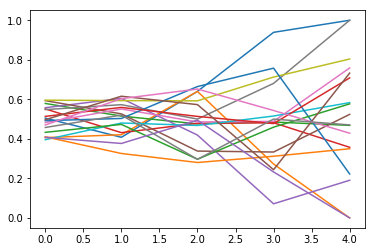

Ecco la matrice generale:
[[4088. 3165.]
 [7031. 6044.]]
Ecco le matrici per percentile
Percentile : 0
[[2161. 1952.]
 [2729. 2374.]]
Percentile : 1
[[ 954.  613.]
 [2327. 2114.]]
Percentile : 2
[[ 472.  345.]
 [1232.  977.]]
Percentile : 3
[[274. 175.]
 [532. 403.]]
Percentile : 4
[[254. 126.]
 [244. 174.]]


In [4]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]
totalconfusion=np.zeros((2,2))
confusionlist=[]
for con in range(0,5):
    confusionlist.append(np.zeros((2,2)))

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    
    #print(xtemp)
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    percfinal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        percentage=[]
        
        yvolatility=[]
        yprice=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open']) 
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(senttemp[i])
        
        y=np.array(y)
        x=np.array(x)
        scaler = MinMaxScaler() 
        scaler.fit(x)
        MinMaxScaler(copy=True, feature_range=(0, 1))
        x=scaler.transform(x)
        yvolatility=np.array(yvolatility)
       
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    


        lspace=[0.01]
        dropspace=[0.5]
        uspace=[512,756]
        learnspace=[0.0001,0.00001]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxu=0
        maxl=0
        maxd=0
        maxle=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                #print()
                for l in lspace:
                    for le in learnspace:
                    
                   
                        print('=========================================================')
                        print('working on d,u and l,le',d,u,l,le)

                        cvacclist=[]
                        #faccio cross validation
                        #start with 40% as train and 10% for validation and then i move in percentege
                        # 0-40 40-50
                        # 0-50 50-60
                        # 0-60 60-70 
                        #etc test set is completely external i do in some way error extimation changin the ticker
                        trainpoint=math.floor(len(x_tv)*0.40)
                        dimval=math.floor(trainpoint*0.25)
                        endval=trainpoint+dimval
                        
                        for i in range(0,6):
                            model=buildModel(l,u,d,le)
                            #print('-----')
                            x_train=x_tv[0:trainpoint]
                            y_train=y_tv[0:trainpoint]
                            x_val=x_tv[trainpoint:endval]
                            y_val=y_tv[trainpoint:endval]

                            trainpoint=trainpoint+dimval
                            endval=endval+dimval

                            x_train,y_train=smote(x_train,y_train)
                            if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                                x_val,y_val=smote(x_val,y_val)
                            else:
                                totu=totu+1

                            history=model.fit(x_train, y_train, epochs = 1000,batch_size =128, verbose=0, validation_data=(x_val, y_val),
                                              shuffle=True)
                            prediction=model.predict(x_val, batch_size=128, verbose=0)
                            for el in range(0,len(prediction)):
                                if(prediction[el]>0.5):
                                    prediction[el]=1
                                else:
                                    prediction[el]=0



                            if(i==0):
                                meanhvl=np.asarray(history.history['val_loss'])
                                meanhva=np.asarray(history.history['val_acc'])
                                meanhl=np.asarray(history.history['loss'])
                                meanha=np.asarray(history.history['acc'])

                            else:
                                meanhvl=np.add(meanhvl,history.history['val_loss'])
                                meanhva=np.add(meanhva,history.history['val_acc'])
                                meanha=np.add(meanha,history.history['acc'])
                                meanhl=np.add(meanhl,history.history['loss'])
                           
                            #i take the last one
                            #maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            #USING G SCORE AS MODEL SELECTION METRIC
                            maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            cvacclist.append(maxAcc)
                            model=None
                            history=None
                            del model
                            del history
                            gc.collect()
                            tf.reset_default_graph()
                            K.clear_session()

                        cvacc=sum(cvacclist)/len(cvacclist)
                        if(cvacc>maxacc):
                            maxacc=cvacc
                            maxu=u
                            maxl=l
                            maxle=le
                            maxd=d


                        meanhvl=meanhvl/6
                        meanhva=meanhva/6
                        meanhl=meanhl/6
                        meanha=meanha/6

                        plt.plot(meanha,'g')
                        plt.plot(meanhva,'r')
                        plt.show()
                        plt.plot(meanhl,'g')
                        plt.plot(meanhvl,'r')
                        plt.show()

                        print('=========================================================')
        model=buildModel(maxl,maxu,maxd,maxle)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs =200,batch_size =128, verbose=0, validation_data=(x_test, y_test),
                                          shuffle=True)
        prediction=model.predict(x_test, batch_size=128, verbose=0)
        predictionscsv = pd.DataFrame(data=prediction,columns=[files[o-1]])
        tempdate=np.array(dates[o-1])
        predictionscsv.index = tempdate[testindex]
        predictionscsv.to_csv('/home/andrea/Desktop/NLFF/technicalAnalysis/NN/Predictions/AffectiveSpace/sgd/news/'+files[o-1]+'.csv')
      
        for el in range(0,len(prediction)):
            if(prediction[el]>0.5):
                prediction[el]=1
            else:
                prediction[el]=0
            
        
        
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('maxd,maxu,maxl,maxle:',maxd,maxu,maxl,maxle)
        print('Chart for BEST MODEL FOR:',files[o-1])
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        acctotal.append(history.history['val_acc'][len(history.history['val_acc'])-1])
        confmatrix=confusion_matrix(y_test, prediction)
        totalconfusion=totalconfusion+confmatrix
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction)
        
        print('F1,score',CM)
        print('G-score:',valueacc)
        realacc=history.history['val_acc'][len(history.history['val_acc'])-1]
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print('Window:',t)
        print(confmatrix)
        print('Vol pos',sum(volr)/len(volr))
        print('Vol neg',sum(voln)/len(voln))
        percnegtotal.append(sum(volr)/len(volr))
        percpostotal.append(sum(voln)/len(voln))
        #build structure to plot distribution onver percentile
        chart=np.zeros(5)
        for r in range(0,len(y_test)):
            for v in range(0,5):
                if(yvolatilitytest[r]<min(yvolatility)+step+step*v and yvolatilitytest[r]>min(yvolatility)+step*v):
                    chart[v]+=1
        #plt.plot(chart)
        #plt.show()
        print('Real Percentage of gain:',(pricegain*100)/(sum(price.iloc[1:6]['open'])))
        pricegainlist.append((pricegain*100)/(sum(price.iloc[1:6]['open'])))
        print('Percentage of gain:',(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('Total gain:',len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        gainlist.append(len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        for g in range(0,len(distribution)):
            print('Percentile: ',g)
            tempscore=0
            if(len(distribution[g])>0):
                predictionp=model.predict(x_test[distribution[g]])
                for el in range(0,len(predictionp)):
                    if(predictionp[el]>0.5):
                        predictionp[el]=1
                    else:
                        predictionp[el]=0
                tempmatrix=confusion_matrix(y_test[distribution[g]], predictionp)
                confusionlist[g]=confusionlist[g]+tempmatrix
                print(tempmatrix)
                print(model.evaluate(x_test[distribution[g]],y_test[distribution[g]]))
                tempscore=model.evaluate(x_test[distribution[g]],y_test[distribution[g]], verbose=0)
            chartscore.append(tempscore[1])    
        chartlist.append(chartscore)
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))
print('Mean gain over portfolio : ', sum(gainlist)/len(gainlist))
print('Real mean gain over portfolio',sum(pricegainlist)/len(pricegainlist))
#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
print('Ecco la matrice generale:')
print(totalconfusion)
print('Ecco le matrici per percentile')
for i in range(0,len(confusionlist)):
    print('Percentile :',i)
    print(confusionlist[i])        

            

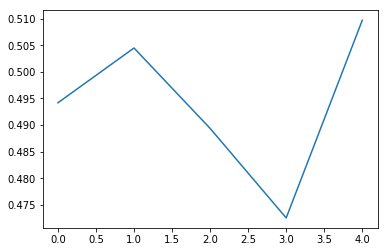

In [5]:
tot=np.zeros(5)
for st in range(0,len(chartlist)):
    tot=chartlist[st]+tot
    
tot=tot/len(chartlist)
plt.plot(tot)
plt.show()

In [ ]:
l=[]
for i in range(0,5):
    l.append(np.zeros((2,2)))
l[0]=l[0]+confmatrix
print(l[0])
print('[[[]]]')
z=np.zeros((2,2))
print(confmatrix)
z=z+confmatrix
print(z)

In [ ]:
tempacc=accstocksresults

In [ ]:
import operator
t=[0,0,0]
for i in range(0,len(tempacc)):
    t=np.add(t,tempacc[i])
print(t)
print(t/len(tempacc))

In [ ]:
Working on... AAPL
/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
Window: 2
[[249  81]
 [263 107]]
F1,score 0.38351254480286734
Accuracy: 0.5085714285714286
Window: 4
[[  0 323]
 [  0 376]]
F1,score 0.6995348837209303
Accuracy: 0.5379113018597997
Window: 6
[[243  85]
 [271 100]]
F1,score 0.35971223021582727
Accuracy: 0.4907010014306152
Window: 10
[[247  77]
 [234 140]]
F1,score 0.4737732656514382
Accuracy: 0.5544412607449857
Window: 16
[[257  67]
 [259 114]]
F1,score 0.4115523465703971
Accuracy: 0.5322812051649928
Window: 24
[[210  96]
 [253 136]]
F1,score 0.43800322061191627
Accuracy: 0.497841726618705
Window: 32
[[192 107]
 [217 178]]
F1,score 0.5235294117647058
Accuracy: 0.5331412103746398
Window: 42
[[219  76]
 [235 162]]
F1,score 0.5102362204724409
Accuracy: 0.5505780346820809
Window: 56
[[245  62]
 [227 155]]
F1,score 0.5175292153589315
Accuracy: 0.5805515239477503
Window: 66
[[  3 316]
 [  0 368]]
F1,score 0.6996197718631179
Accuracy: 0.5400291120815138
Window: 87
[[272  61]
 [197 153]]
F1,score 0.5425531914893618
Accuracy: 0.6222547584187409
Window: 100
[[188 135]
 [138 219]]
F1,score 0.6160337552742615
Accuracy: 0.5985294117647059
Window: 112
[[188 129]
 [134 227]]
F1,score 0.6331938633193863
Accuracy: 0.612094395280236
Window: 125
[[266  46]
 [236 127]]
F1,score 0.47388059701492535
Accuracy: 0.5822222222222222
Window: 140
[[315  24]
 [258  75]]
F1,score 0.3472222222222222
Accuracy: 0.5803571428571429
Window: 160
[[329  46]
 [172 121]]
F1,score 0.5260869565217392
Accuracy: 0.6736526946107785
Window: 175
[[365  15]
 [227  58]]
F1,score 0.3240223463687151
Accuracy: 0.6360902255639098
Window: 190
[[123 236]
 [ 57 246]]
F1,score 0.6267515923566879
Accuracy: 0.5574018126888217
Window: 205
[[ 27 314]
 [ 34 284]]
F1,score 0.6200873362445416
Accuracy: 0.47192716236722304
Window: 220
[[312   9]
 [294  41]]
F1,score 0.21298701298701297
Accuracy: 0.538109756097561
Window: 245
[[  0 260]
 [  0 391]]
F1,score 0.7504798464491362
Accuracy: 0.6006144393241167
Window: 260
[[246   7]
 [291 104]]
F1,score 0.41106719367588934
Accuracy: 0.5401234567901234
Window: 300
[[ 29 228]
 [ 48 335]]
F1,score 0.7082452431289641
Accuracy: 0.56875
Window: 350
[[127 109]
 [124 270]]
F1,score 0.6985769728331177
Accuracy: 0.6301587301587301
Window: 400
[[ 12 248]
 [ 17 343]]
F1,score 0.7213459516298634
Accuracy: 0.5725806451612904
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 45, 45, 45]
[0.5085714285714286, 0.5379113018597997, 0.4907010014306152, 0.5544412607449857, 0.5322812051649928, 0.497841726618705, 0.5331412103746398, 0.5505780346820809, 0.5805515239477503, 0.5400291120815138, 0.6222547584187409, 0.5985294117647059, 0.612094395280236, 0.5822222222222222, 0.5803571428571429, 0.6736526946107785, 0.6360902255639098, 0.5574018126888217, 0.47192716236722304, 0.538109756097561, 0.6006144393241167, 0.5401234567901234, 0.56875, 0.6301587301587301, 0.5725806451612904]
accuracy
accuracy
#old with f1 score in model selection
aapl=[0.5213675213675214, 0.5327635327635327, 0.5242165242165242, 0.5278174037089871, 0.5228571428571429, 0.5444126074498568, 0.5589080459770115, 0.5662824207492796, 0.5433526011560693, 0.5130434782608696, 0.5883211678832116, 0.6881405563689604, 0.6852941176470588, 0.5353982300884956, 0.5422222222222223, 0.4157973174366617, 0.4041916167664671, 0.44511278195488724, 0.48338368580060426, 0.5128983308042488, 0.6131498470948012, 0.6236559139784946, 0.6003110419906688, 0.627172195892575, 0.5826645264847512]
adbe=[0.5498575498575499, 0.5698005698005698, 0.5783475783475783, 0.6148359486447932, 0.6414285714285715, 0.6575931232091691, 0.6752873563218391, 0.6772334293948127, 0.6734104046242775, 0.6652173913043479, 0.6802919708029197, 0.6881405563689604, 0.7147058823529412, 0.7684365781710915, 0.7911111111111111, 0.8002980625931445, 0.7754491017964071, 0.7894736842105263, 0.8187311178247734, 0.8634294385432474, 0.8929663608562691, 0.9139784946236559, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.51994301994302, 0.5341880341880342, 0.550641940085592, 0.5428571428571428, 0.5464949928469242, 0.5544412607449857, 0.5502873563218391, 0.5749279538904899, 0.6034732272069464, 0.5892597968069666, 0.5883211678832116, 0.5791788856304986, 0.5441176470588235, 0.518463810930576, 0.46735905044510384, 0.45671641791044776, 0.4587706146926537, 0.4879518072289157, 0.5128593040847201, 0.5486322188449848, 0.4946401225114854, 0.5261538461538462, 0.557632398753894, 0.7215189873417721, 0.6270096463022508]
googl=[0.496551724137931, 0.5189655172413793, 0.5413793103448276, 0.538860103626943, 0.5657439446366782, 0.5538194444444444, 0.5679442508710801, 0.5856643356643356, 0.5421052631578948, 0.5475352112676056, 0.5808170515097691, 0.5508021390374331, 0.517921146953405, 0.4748201438848921, 0.42857142857142855, 0.3825136612021858, 0.36813186813186816, 0.3664825046040516, 0.37777777777777777, 0.3817504655493482, 0.37969924812030076, 0.43478260869565216, 0.5950095969289827, 0.5694716242661448, 0.592814371257485]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
tot=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
#new with accuracy in model selection
aapl=[0.5252976190476191, 0.5320417287630402, 0.5171385991058122, 0.5164179104477612, 0.5186846038863976, 0.5412293853073463, 0.551051051051051, 0.5542168674698795, 0.5370650529500757, 0.5174506828528073, 0.5114503816793893, 0.6380368098159509, 0.5169230769230769, 0.517774343122102, 0.47360248447204967, 0.415625, 0.41130298273155413, 0.45425867507886436, 0.47385103011093505, 0.4888535031847134, 0.5826645264847512, 0.5935483870967742, 0.5800653594771242, 0.6079734219269103, 0.5608108108108109]
adbe=[0.5484330484330484, 0.5669515669515669, 0.5740740740740741, 0.6105563480741797, 0.6371428571428571, 0.660458452722063, 0.6810344827586207, 0.6873198847262247, 0.6748554913294798, 0.6681159420289855, 0.6802919708029197, 0.6925329428989752, 0.7176470588235294, 0.7743362831858407, 0.794074074074074, 0.8107302533532041, 0.7859281437125748, 0.7984962406015037, 0.8157099697885196, 0.858877086494689, 0.8929663608562691, 0.9109062980030722, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.5155763239875389, 0.5179407176287052, 0.5226209048361935, 0.515625, 0.5258215962441315, 0.5196232339089482, 0.5125786163522013, 0.5031545741324921, 0.5134706814580031, 0.47217806041335453, 0.4384, 0.44694533762057875, 0.4338709677419355, 0.4359805510534846, 0.38925081433224756, 0.41475409836065574, 0.42504118616144976, 0.46357615894039733, 0.34608985024958405, 0.5284280936454849, 0.47386172006745364, 0.4864406779661017, 0.35738831615120276, 0.6888111888111889, 0.7135231316725978]
googl=[0.5153970826580226, 0.5340909090909091, 0.538961038961039, 0.551219512195122, 0.5765472312703583, 0.5620915032679739, 0.5891980360065466, 0.6042692939244664, 0.40594059405940597, 0.4685430463576159, 0.335, 0.7437185929648241, 0.7411764705882353, 0.7381756756756757, 0.7181663837011885, 0.4017094017094017, 0.29896907216494845, 0.5958549222797928, 0.2465277777777778, 0.23734729493891799, 0.653169014084507, 0.6513274336283186, 0.7809694793536804, 0.2340036563071298, 0.1303538175046555]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
totnew=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
plt.plot(trendwindowtime,tot,'r')
plt.plot(trendwindowtime,totnew,'g')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
trendwindowtime=[2,4,6,10,16,24,32,42,56,66,87,100,112,125,140,160,175,190,205,220,245,260,300,350,400]

a=[0.52192995, 0.53892941 ,0.54864634 ,0.55609265, 0.56913116 ,0.57756661,
 0.58810675, 0.60102703, 0.59058537, 0.57876397, 0.60943784 ,0.62656553,
 0.6155097,  0.57427969, 0.55731595, 0.51383136 ,0.5016358,  0.52225519,
 0.54818797, 0.57667761, 0.59511389 ,0.62464272, 0.68551664, 0.72796092,
 0.70062214]
b=[0.51760779 ,0.52952612, 0.53490195, 0.53742601, 0.54627483 ,0.54998215,
 0.56540344, 0.58600154 ,0.58753407 ,0.57731507, 0.594899   ,0.5961274,
 0.59153927 ,0.58697463, 0.55879766, 0.53795722, 0.53334514 ,0.56295701,
 0.58163702 ,0.60455733, 0.62554647 ,0.65463482 ,0.71007133 ,0.7335257,
 0.68877474]
c=[0.52099555, 0.5337735 , 0.53833449, 0.54061983 ,0.55396823 ,0.55690408,
 0.57024055, 0.58414245, 0.59335293, 0.58858148, 0.61281755, 0.61071544,
 0.61790589, 0.63407592 ,0.62393464 ,0.61431855, 0.60202487 ,0.6046186,
 0.60656568 ,0.62321505 ,0.64674124, 0.65245534, 0.73430844, 0.76789561,
 0.74018119]
d=[0.52282555, 0.53986176, 0.54463966 ,0.54846378 ,0.56177553 ,0.58579719,
 0.59445897 ,0.59920915, 0.5909525 , 0.58121757, 0.59267087 ,0.59938036,
 0.59060086 ,0.58884745, 0.55975116 ,0.53407032, 0.52909452,0.54840958,
 0.57406494, 0.60228516, 0.62788511, 0.65007699 ,0.68774144, 0.73405107,
 0.70384762]
e=[0.52243865, 0.53663027 ,0.54537545, 0.55677058 ,0.5728499 , 0.58627962,
 0.60346285 ,0.61262476, 0.61037032 ,0.60298479 ,0.62605434, 0.66117335,
 0.65966471 ,0.62698978, 0.6261062 , 0.57038208, 0.56864994 ,0.5883435,
 0.60814613, 0.62989858, 0.64787428 ,0.67262909 ,0.7058909 , 0.75028496,
 0.72055658]
f=[0.5238604 , 0.53881766, 0.54561249, 0.5536881 , 0.5689674 , 0.59312321,
 0.60452586 ,0.6120317 , 0.59615891 ,0.58592951, 0.62335766,0.60526324,
 0.59779412 ,0.59643011, 0.56313606, 0.53631025 ,0.53048607 ,0.56524198,
 0.57685531, 0.60529159, 0.62404229 ,0.64843554, 0.70316929 ,0.74870518,
 0.72055658]
g=[0.52246465, 0.53817575, 0.54286319, 0.54822634 ,0.56302575 ,0.57261693,
 0.58757837, 0.60089967 ,0.59200024, 0.58167815, 0.59812454, 0.60119231,
 0.59054402 ,0.58859025, 0.55670147 ,0.52958314, 0.52837084, 0.55018158,
 0.57541237, 0.59998367, 0.62075483 ,0.64301379, 0.6930744 ,0.73912468,
 0.70964223]
plt.plot(trendwindowtime,a,'r')
plt.plot(trendwindowtime,b,'g')
plt.plot(trendwindowtime,c,'b')
plt.plot(trendwindowtime,d,'y')
plt.plot(trendwindowtime,e,'c')
plt.plot(trendwindowtime,f,'b')
plt.plot(trendwindowtime,g,'m')
plt.show()





In [ ]:
space=np.concatenate(((np.logspace(0,3,15)),np.logspace(-4,4,10)))
print(space)
plt.plot(space)
plt.show()